In [1]:
# Magic functions -- Run Once
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import matplotlib.pyplot as plt
# Set default figure size
plt.rcParams["figure.figsize"] = (12, 5)

import warnings
# Ignore all warnings (This might not be a good idea)
warnings.filterwarnings('ignore')

# Move up one folder to reach the repo root
%cd ..

from utils.notebook.generic import full_width_notebook
# Set notebook to 100% width
full_width_notebook()

/home/abdj2702/dev/maitrise/film-aqa


In [16]:
from main import parse_args_string, prepare_for_task
from utils.notebook.generic import notebook_input_prompt
from utils.visualization import show_tagged_scene, get_tagged_scene_table_legend
from runner import custom_question_inference

data_version_name = "CLEAR_50k_4_inst_1024_win_50_overlap"
model_restore_path = "/archive/abdj2702/synced_training/CLEAR_50k_4_inst_1024_win_50_overlap_extractor_parallel_3_block_64_proj_40_epoch_876944_extractor/2020-05-13_22h49"
#model_restore_path = "output/training/v3_fixed_5k_40_inst_1024_win_50_overlap_hpc-puget-necotis/latest"

data_root_path = "data"
#config_path = "config/reduction/original_rnn_256.json"
config_path = f"{model_restore_path}/config_raw_h5_input.json"
#config_path = "output/training/v3_fixed_5k_40_inst_1024_win_50_overlap_hpc-puget-necotis/latest/config_conv_input.json"
random_seed = 876944
image_height = 224
image_width = 224

# TODO : Retrieve params from {model_restore_path}
# TODO : What happen when processed with resnet ?

use_cpu = True

# Model weight restore
model_weight_path = f"{model_restore_path}/best/model.pt.tar"
model_dict_file_path = f"{model_restore_path}/dict.json"

# FIXME : Clear mean & std might be wrong (It is written in the config file)

arguments = (
    f"--notebook_model_inference --version_name {data_version_name} --config_path {config_path} --batch_size 4 "
    f"--random_seed {random_seed} --dict_folder questions "
    f"--h5_image_input "
    #f"--raw_img_resize_val {image_size} --no_feature_extractor --normalize_with_clear_stats "
    f"--film_model_weight_path {model_weight_path} --dict_file_path {model_dict_file_path} {'--use_cpu' if use_cpu else ''}"
)

#  
            
args = parse_args_string(arguments)
task_and_more, dataloaders, model_and_more = prepare_for_task(args)
task, args, flags, paths, device = task_and_more
film_model_config, film_model, optimizer, loss_criterion, scheduler, tensorboard = model_and_more
datasets = {set_type:dloader.dataset for set_type, dloader in dataloaders.items()}

# Retrieve clear stats
import json
with open(f"{data_root_path}/{data_version_name}/clear_stats.json", 'r') as f:
    clear_stats = json.load(f)

# Print model summary
with open(f"{model_restore_path}/model_summary.txt", 'r') as f:
    print(f.read())
    
with open(f"{model_restore_path}/stats.json", 'r') as f:
    stats = json.load(f)
    
with open(f"{model_restore_path}/arguments.json", 'r') as f:
    args = json.load(f)

# TODO: Check if exist first
with open(f"{model_restore_path}/test_stats.json", 'r') as f:
    test_stats = json.load(f)

print(f"Model was trained for {len(stats)} epoch on {args['version_name']}")
print(f"Achieved {float(stats[0]['train_acc'])*100:.2f}% on training set and {float(stats[0]['val_acc'])*100:.2f}% on validation set")
print(f"Got {float(test_stats['accuracy'])*100:.2f}% on test set ({test_stats['version_name']})")



Task 'Notebook Model Inference' for version 'CLEAR_50k_4_inst_1024_win_50_overlap'

Using device 'cpu'
Creating Datasets
Tokenizer
Tokenizer
Tokenizer
Creating Dataloaders
{'id': 0, 'image': {'id': 0, 'filename': 'CLEAR_train_000000.png', 'set': 'train'}, 'question': [2, 85, 75, 37, 53, 67, 37, 19, 64, 88, 6, 83, 37, 55, 70, 88, 72, 3], 'answer': 9, 'program': [{'_output': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'inputs': [], 'type': 'scene', 'value_inputs': []}, {'_output': [0, 2, 8], 'inputs': [0], 'type': 'filter_brightness', 'value_inputs': ['bright']}, {'_output': [8], 'inputs': [1], 'type': 'filter_loudness', 'value_inputs': ['quiet']}, {'_output': 8, 'inputs': [2], 'type': 'unique', 'value_inputs': []}, {'_output': [0, 1, 2, 3, 4, 5, 6, 7], 'inputs': [3], 'type': 'relate', 'value_inputs': ['before']}, {'_output': [4, 5, 7], 'inputs': [4], 'type': 'filter_brightness', 'value_inputs': ['dark']}, {'_output': [7], 'inputs': [5], 'type': 'filter_instrument', 'value_inputs': ['clarinet']}, {

In [49]:
# Retrieve random game
set_type = 'train'
random_game = datasets[set_type].get_random_game(return_game=True)
scene_id = random_game['scene_id']

<IPython.core.display.Javascript object>


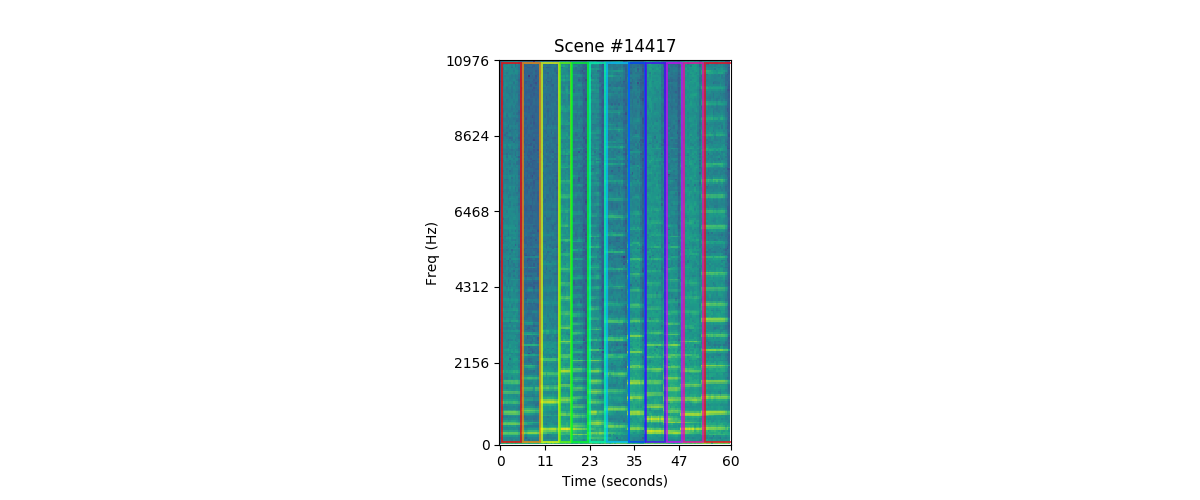

,0,1,2,3,4,5,6,7,8,9,10,11
instrument,flute,clarinet,clarinet,violin,cello,cello,violin,trumpet,flute,trumpet,flute,violin
loudness,quiet,quiet,loud,loud,quiet,loud,quiet,loud,loud,loud,loud,loud
brightness,dark,bright,bright,dark,bright,bright,bright,None,None,None,bright,bright
note,D,D#,G,G#,C,D,B,A,F,D#,G#,A
duration,4954,4507,4630,2921,3882,3979,5743,3902,4939,3976,5167,7140
id,40,15,51,33,45,22,55,41,1,23,24,16


[Boolean]Question (57668):                        Answer for proposed question: no


[Instrument]Question (57669):                     Answer for proposed question: cello


[Position]Question (57670):                       Answer for proposed question: third



No question of family position_global for this scene


No question of family count for this scene


No question of family note for this scene


No question of family loudness for this scene


No question of family brightness for this scene



In [50]:
# Show scene & Example questions
from utils.notebook.inference import show_game_notebook_input

custom_question, custom_questions, legend = show_game_notebook_input(dataloaders[set_type], random_game, clear_stats,
                                                                     remove_image_padding=True)

In [51]:
from utils.notebook.inference import do_custom_question_inference, show_gradcam

# MODIFY THIS TO GET GRADCAM FOR DIFFERENT GUESSES
gradcam_guess_id = 0

custom_game, top_preds = do_custom_question_inference(device, film_model, dataloaders[set_type], custom_question, scene_id, nb_top_pred=5)
display(legend)

Question : What instrument plays a loud bright d note before the b note ?
Correct Answer

  Guess 0:                     Cello ---- 0.99992835521698
  Guess 1:                    Violin ---- 5.0470127462176606e-05
  Guess 2:                         F ---- 9.123158633883577e-06
  Guess 3:                    Second ---- 4.061308118252782e-06
  Guess 4:                     Flute ---- 1.7565711232236936e-06


,0,1,2,3,4,5,6,7,8,9,10,11
instrument,flute,clarinet,clarinet,violin,cello,cello,violin,trumpet,flute,trumpet,flute,violin
loudness,quiet,quiet,loud,loud,quiet,loud,quiet,loud,loud,loud,loud,loud
brightness,dark,bright,bright,dark,bright,bright,bright,None,None,None,bright,bright
note,D,D#,G,G#,C,D,B,A,F,D#,G#,A
duration,4954,4507,4630,2921,3882,3979,5743,3902,4939,3976,5167,7140
id,40,15,51,33,45,22,55,41,1,23,24,16


,0,1,2,3,4,5,6,7,8,9,10,11
instrument,flute,clarinet,clarinet,violin,cello,cello,violin,trumpet,flute,trumpet,flute,violin
loudness,quiet,quiet,loud,loud,quiet,loud,quiet,loud,loud,loud,loud,loud
brightness,dark,bright,bright,dark,bright,bright,bright,None,None,None,bright,bright
note,D,D#,G,G#,C,D,B,A,F,D#,G#,A
duration,4954,4507,4630,2921,3882,3979,5743,3902,4939,3976,5167,7140
id,40,15,51,33,45,22,55,41,1,23,24,16


### GradCam visualization Guess #1  ---- [cello]

<IPython.core.display.Javascript object>


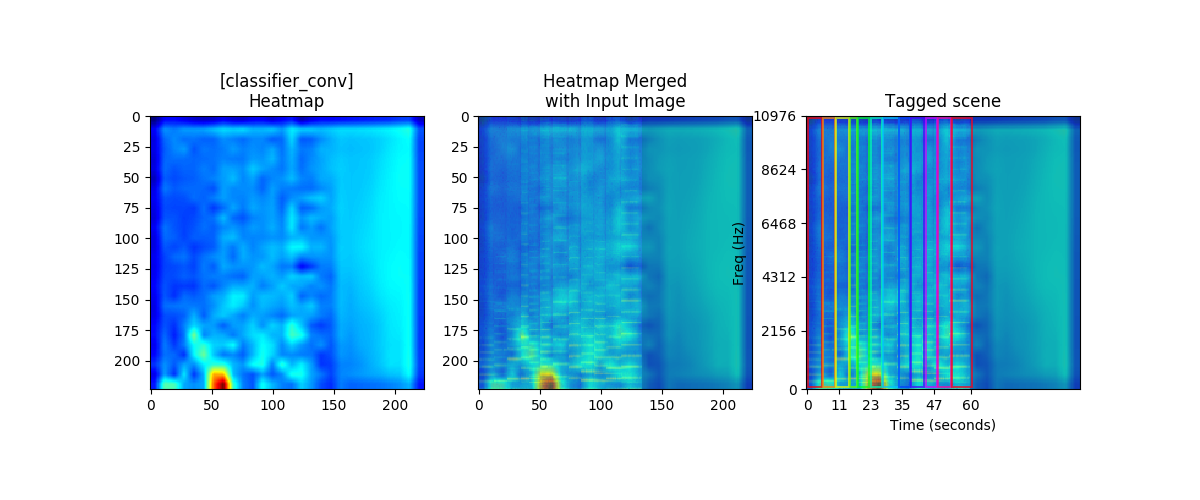

In [52]:
layers_to_observe = {
    #'stem_conv': film_model.stem_conv,
    #'resblocks[0].conv1': film_model.resblocks[0].conv1,
    #'resblocks[0].conv2': film_model.resblocks[0].conv2,
    #'resblocks[0].film_layer': film_model.resblocks[0].film_layer,
    #'resblocks[0]': film_model.resblocks[0],
    #'resblocks[1].conv1': film_model.resblocks[1].conv1,
    #'resblocks[1].conv2': film_model.resblocks[1].conv2,
    #'resblocks[1].film_layer': film_model.resblocks[1].film_layer,
    #'resblocks[1]': film_model.resblocks[1],
    #'resblocks[2].conv1': film_model.resblocks[2].conv1,
    #'resblocks[2].conv2': film_model.resblocks[2].conv2,
    #'resblocks[2].film_layer': film_model.resblocks[2].film_layer,
    #'resblocks[2]': film_model.resblocks[2],
    #'resblocks[3].conv1': film_model.resblocks[3].conv1,
    #'resblocks[3].conv2': film_model.resblocks[3].conv2,
    #'resblocks[3].film_layer': film_model.resblocks[3].film_layer,
    #'resblocks[3]': film_model.resblocks[3],
    'classifier_conv': film_model.classifier.classif_conv
    #'classifier.logits': film_model.classifier.logits
}

display(legend)
heatmaps = show_gradcam(device, film_model, dataloaders[set_type], custom_game, scene_id, guess_id=gradcam_guess_id, 
                        top_preds=top_preds, clear_stats=clear_stats, apply_relu=True, target_layers=layers_to_observe)

In [ ]:
hook_handles = []

In [ ]:
from torch import nn

activations = {}
weights = {}
biases = {}

def forward_hook(name):
    def hook(module, inp, output):
        activations[name] = output
        if isinstance(module, nn.Sequential):
            for m in module:
                if isinstance(m, nn.Conv2d):
                    weights[name] = m.weight
                    
                    biases[name] = m.bias
        
    return hook

for layer_name, layer in layers_to_observe.items():
    hook_handles.append(layer.register_forward_hook(forward_hook(layer_name)))

In [ ]:
for hook in hook_handles:
    hook.remove()

In [ ]:
weights['stem_conv'].shape

In [ ]:
activations['stem_conv'].min()

In [ ]:
from torchvision.utils import make_grid
import numpy as np
def show(img):
    npimg = img.numpy()
    
    plt.figure()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    #plt.imshow(npimg, interpolation='nearest')
    
def separate_features(activations):
    bs, c, h, w = activations.size()
    assert bs == 1, "Only work for batch size of 1"
    # Remove batch size
    activations = activations.reshape((c,h,w))
    activations = activations.div(activations.max())
    return list(activations.split(1, dim=0))

#show(separate_features(activations['stem_conv'])[0])


normalized_activations = activations['classifier.logits'].sub(activations['classifier.logits'].min()).div(activations['classifier.logits'].max().sub(activations['classifier.logits'].min()))
separated_feature_maps = separate_features(activations['resblocks[3].film_layer'])
show(make_grid(separated_feature_maps[:32], nrow=10))
show(make_grid(separated_feature_maps[32:64], nrow=10))
show(make_grid(separated_feature_maps[64:96], nrow=10))
show(make_grid(separated_feature_maps[96:], nrow=10))

In [ ]:
separated_feature_maps = separate_features(activations['resblocks[3].conv2'])
show(make_grid(separated_feature_maps[:32], nrow=10))
show(make_grid(separated_feature_maps[32:64], nrow=10))
show(make_grid(separated_feature_maps[64:96], nrow=10))
show(make_grid(separated_feature_maps[96:], nrow=10))

In [ ]:
import torch.nn.functional as F

feature_map = F.upsample(separated_feature_maps[0].unsqueeze(0), size=random_game['image'].size()[1:], mode='bilinear', align_corners=False)

heatmap, result = visualize_cam(feature_map, random_game['image'])

In [ ]:
#show(heatmap)

img_min = random_game['image'].min()
normalized = random_game['image'].sub(img_min).div(random_game['image'].max() - img_min)

heatmaps = []
combined = []
for feature_map in separated_feature_maps:
    upsampled = F.upsample(feature_map.unsqueeze(0), size=random_game['image'].size()[1:], mode='bilinear', align_corners=False)
    up_min = upsampled.min()
    upsampled = upsampled.sub(up_min).div(upsampled.max() - up_min)
    heatmap, result = visualize_cam(upsampled, normalized)
    
    heatmaps.append(heatmap)
    combined.append(result)
    
show(make_grid(heatmaps))
show(make_grid(combined))

In [ ]:
print(heatmaps[28].mean())
show(heatmaps[28])

In [ ]:
plt.figure()
plt.imshow(separated_feature_maps[0].squeeze(0).numpy(), interpolation='nearest')


#show(separated_feature_maps[0])

In [ ]:
to_plot = []

for i, feature_map in enumerate(separated_feature_maps):
    silence_mean = feature_map[0,:, 10:].sum()
    rest_mean = feature_map[0,:, :10].sum()
    
    if silence_mean > rest_mean:
        print(i)
        to_plot.append(feature_map)

show(make_grid(to_plot, normalize=True))

In [ ]:
import torch
def visualize_cam(mask, img):
    """ Taken from https://github.com/vickyliin/gradcam_plus_plus-pytorch
    Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]

    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    import cv2       # Not an official dependency
    heatmap = (255 * mask.squeeze()).type(torch.uint8).cpu().numpy()
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])

    result = heatmap*0.2+img.cpu()
    min_val = result.min()
    result = result.sub(min_val).div(result.max().sub(min_val)).squeeze()

    return heatmap, result